In [1]:
import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)


figure_save_path = Path(parent_dir) / 'figures'
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
from tqdm import tqdm
from models.llama import get_model_and_tokenizer


def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black', alpha = 0.3)
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.15, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(f'plot_output/{current_time}.png')

    plt.show()
    

def llama_completion_fn(
    model,
    tokenizer,
    input_str,
    steps, # len(test[0])
    settings,
    batch_size=1,
    num_samples=20,
    temp=0.9, 
    top_p=0.9
):
    input_len = len(input_str.split(settings.time_sep))
    avg_tokens_per_step = len(input_str)/input_len
    max_tokens = int(avg_tokens_per_step*steps)
    
    
    good_tokens_str = list("0123456789" + settings.time_sep)
    good_tokens = [tokenizer.convert_tokens_to_ids(str) for str in good_tokens_str]
    good_tokens += [tokenizer.eos_token_id]
    bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
    
    batch = tokenizer([input_str], return_tensors="pt")
    batch = {k: v.cuda() for k, v in batch.items()}
    
    gen_strs = []
    for _ in tqdm(range(num_samples // batch_size)):
        generate_ids = model.generate(
            **batch,
            do_sample=True,
            max_new_tokens=max_tokens,
            temperature=temp, 
            top_p=top_p, 
            bad_words_ids=[[t] for t in bad_tokens],
            renormalize_logits=True,
            use_cache=True,  # Enable kv caching
        )
        gen_strs += tokenizer.batch_decode(
            generate_ids, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=False
        )

    gen_strs = [x.replace(input_str, '').strip() for x in gen_strs]

    return gen_strs

### Define PDE and concatenate in time/space

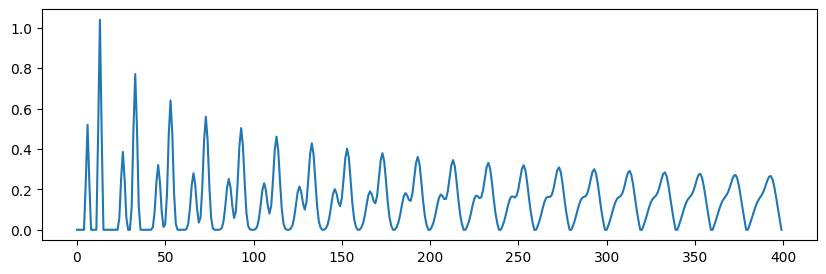

In [2]:
# Parameters
D = 6  # Diffusion coefficient
dx = 0.5  # Space step
L = 10  # Length of the 1D space

dt = 0.01  # Time step
T = 0.2  # Total time
Nx = int(L/dx)  # Number of spatial points
Nt = int(T/dt)  # Number of time steps

# Initialize concentration (u)
u = np.zeros(Nx)
# Initial condition:
u[Nx//3] = 1  # a single spike of concentration 1
u[Nx*2//3] = 2  # a single spike of concentration 2

# Time series container
time_series = []

# Time-stepping loop
for n in range(0, Nt):
    u_new = np.copy(u)
    for i in range(1, Nx-1):
        u_new[i] = u[i] + D * dt / dx**2 * (u[i+1] - 2*u[i] + u[i-1])
    
    # Fix boundary conditions at u = 0
    u_new[0] = 0
    u_new[-1] = 0
    
    u = u_new 
    # Concatenate to form a single time series
    time_series.extend(u)

# Store the time series in a Pandas DataFrame

X = np.array(time_series)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.plot(X)

### Rescale series to range 0.15~0.85

In [3]:
prec = 2
settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
def serialize(rescaled_array): 
    string_series = serialize_arr(rescaled_array, settings)
    return (string_series)  

def deserialize(string_series):
    return deserialize_str(string_series, settings, ignore_last=True)

In [4]:
### Final range is from 0.15 to 0.85
time_series = X
rescale_factor = 0.7
up_shift = 0.15
rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift


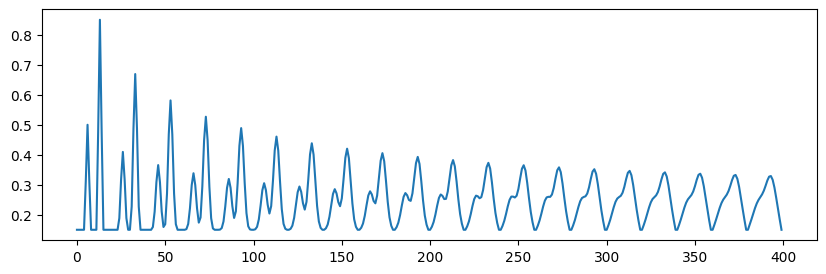

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.plot(rescaled_array)



### Pick auto-regressive completion starting points

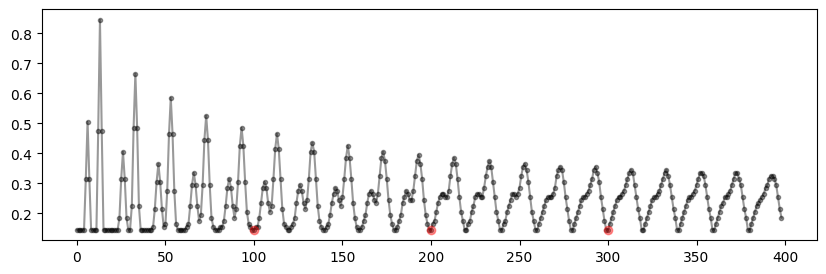

In [5]:
### visualize starting points to continue from

array_from_string = deserialize(serialize(rescaled_array))
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
axs.plot(array_from_string, color='black', marker = '.', alpha = 0.4)

branch_start_list = (L/dx * np.array([5, 10, 15])).astype(int)
# branch_start_list = (L/dx * np.array([1])).astype(int)

for idx in branch_start_list:
    axs.plot(idx, array_from_string[idx], color='red', marker = 'o', alpha = 0.4)


In [21]:
# Continue from list of starting point
branch_length = int(L/dx) * 5
num_samples = 1
model = '70b'
model, tokenizer = get_model_and_tokenizer(model)
branch_list = []
for starting in branch_start_list:
    input_string = serialize(rescaled_array[:starting])   
    print("starting point ", starting)
    prediction_str_list = llama_completion_fn(model, tokenizer,input_string,branch_length, settings,batch_size=1,num_samples=num_samples, temp=0.01)
    prediction_arr_list = [deserialize(prediction_str) for prediction_str in prediction_str_list]
    prediction_arr_padded_list = [np.pad(prediction_arr, (starting, 0), 'constant', constant_values=(np.nan,)) for prediction_arr in prediction_arr_list]
    branch_list += prediction_arr_padded_list

with open('PDE_branch_list_70b.pkl', 'wb') as f:
    pickle.dump(branch_list, f)


starting point  100


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [43:01<00:00, 2581.14s/it]


starting point  200


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
with open('PDE_branch_list_70b.pkl', 'rb') as f:
    branch_list = pickle.load(f)

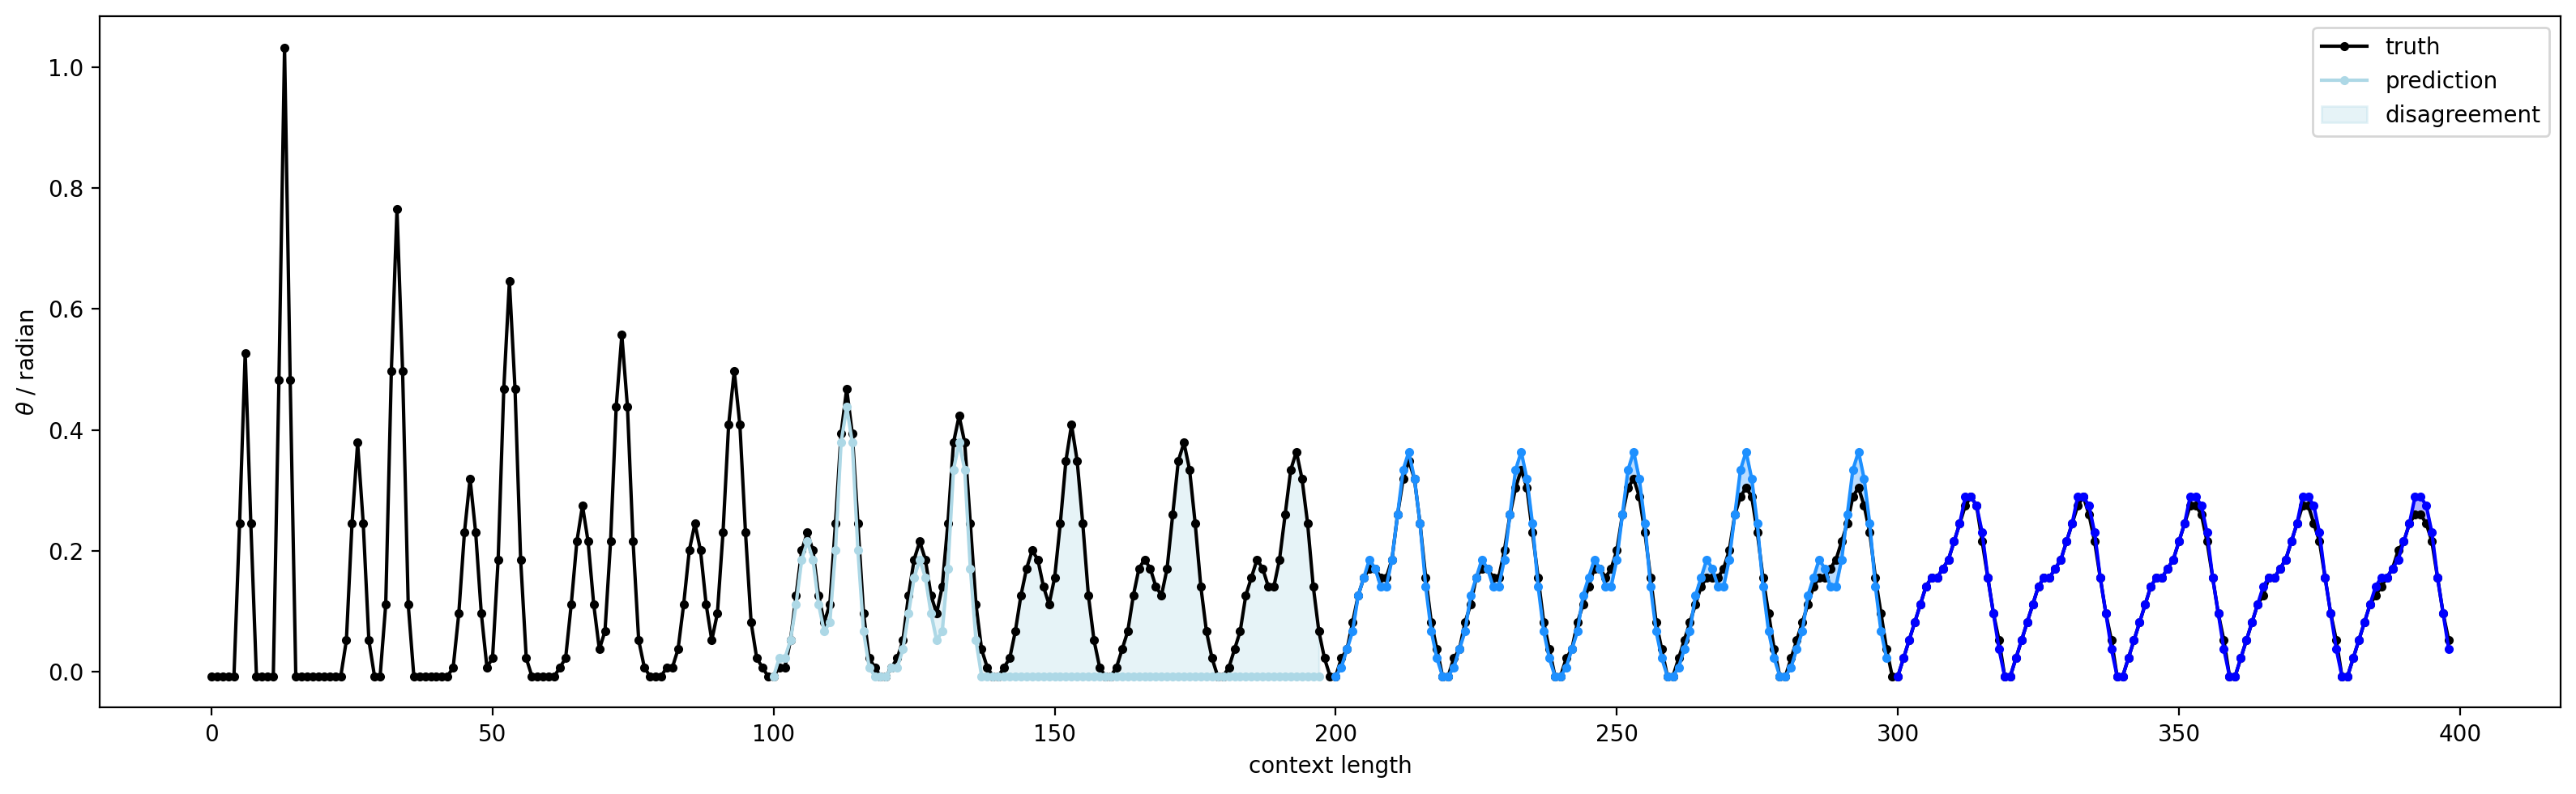

In [7]:
from matplotlib.ticker import FuncFormatter

# Your existing code
array_from_string = deserialize(serialize(rescaled_array))
fig, axs = plt.subplots(1, 1, figsize=(16, 5), dpi = 200)
array_from_string_rescaled = (array_from_string-up_shift)/rescale_factor*(time_series.max()-time_series.min())+time_series.min()
axs.plot(array_from_string_rescaled, 
         color='black', marker = '.', 
         alpha = 1, 
         label = "truth")

colors = ['lightblue', 'dodgerblue', 'blue']
for idx, branch in enumerate(branch_list):
    branch_rescaled = (branch-up_shift)/rescale_factor*(time_series.max()-time_series.min())+time_series.min()
    if idx == 0:
        axs.plot(branch_rescaled, 
                 color=colors[idx], alpha = 1, marker = '.', 
                 label = 'prediction')
        axs.fill_between(range(len(branch_rescaled)), branch_rescaled, array_from_string_rescaled[:len(branch)], color=colors[idx], alpha=0.3,
                         label = 'disagreement')
    else:
        axs.plot(branch_rescaled, color=colors[idx], alpha = 1, marker = '.')
        axs.fill_between(range(len(branch_rescaled)), branch_rescaled, array_from_string_rescaled[:len(branch_rescaled)], color=colors[idx], alpha=0.3)

plt.xlabel("context length")
plt.ylabel(r"$\theta$ / radian")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("PDF_auto_completion_plot_70b")
plt.show()